In [1]:
import joblib
import shap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [2]:
df_A = pd.read_csv('Final_EVSE_A.csv')
df_B = pd.read_csv('Final_EVSE_B.csv')

def prepare_categorical_output(y):
    # # Print the `y` matrix before encoding
    # print("y matrix before encoding:\n", y)

    # Convert Series to NumPy array and reshape `y` matrix
    y = y.values.reshape(-1, 1)

    # Print the `y` matrix after reshaping
    # print("y matrix after reshaping:\n", y)
    
    # One-hot encode the target variable
    encoder = OneHotEncoder(sparse_output=False)
    y = encoder.fit_transform(y)

    # Print the `y` matrix after one-hot encoding
    # print("y matrix after one-hot encoding:\n", y)
    
    return y

#Considering B charging station as training and A as testing

def assigning_set(df1, df2):
    # Group by 'CSVNameFile' and split the last 20% of each group into the validation set
    train_list = []
    val_list = []

    grouped = df1.groupby('CSVNameFile')

    for _, group in grouped:
        split_index = int(len(group) * 0.8)
        train_list.append(group.iloc[:split_index])
        val_list.append(group.iloc[split_index:])

    # Concatenate the training and validation sets
    train_df = pd.concat(train_list).reset_index(drop=True)
    val_df = pd.concat(val_list).reset_index(drop=True)

    # Separate features and labels for train and validation sets
    X_train = train_df.drop(columns=['CSVNameFile', 'status', 'multiclass'])
    y_train = prepare_categorical_output(train_df['multiclass'])

    X_val = val_df.drop(columns=['CSVNameFile', 'status', 'multiclass'])
    y_val = prepare_categorical_output(val_df['multiclass'])

    # X_test and y_test from df2 remain unchanged for test evaluation
    X_test = df2.drop(columns=['CSVNameFile', 'status', 'multiclass'])
    y_test = prepare_categorical_output(df2['multiclass'])

    input_dim = X_train.shape[1]
    output_dim = len(np.unique(df1['multiclass']))

    return X_train, X_val, X_test, y_train, y_val, y_test, input_dim, output_dim

X_train, X_val, X_test, y_train, y_val, y_test, input_dim, output_dim = assigning_set(df_B, df_A)

In [ ]:
# For MLP

In [9]:
# # Load the saved SHAP values
# shap_values = joblib.load(f'mlp_model_shap_values.joblib')

# # Define feature names and class names
# feature_names = X_test.columns
# class_names = ['Benign', 'DoS', 'Recon']

# # Plot SHAP summary plot
# shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)

# # Modify legend to use real class names
# legend = plt.gca().get_legend()
# for i, text in enumerate(legend.get_texts()):
#     text.set_text(class_names[i])

# # Add a title and save the plot
# # plt.gcf().text(0.5, 0.99, f'SHAP Summary Plot for {model_name}', ha='center', fontsize=15)
# plt.xlabel("Mean (|SHAP Value|)", fontsize=12)
# plt.savefig(f'mlp_model_shap_summary_plot_with_title.pdf', bbox_inches='tight')
# plt.show()  

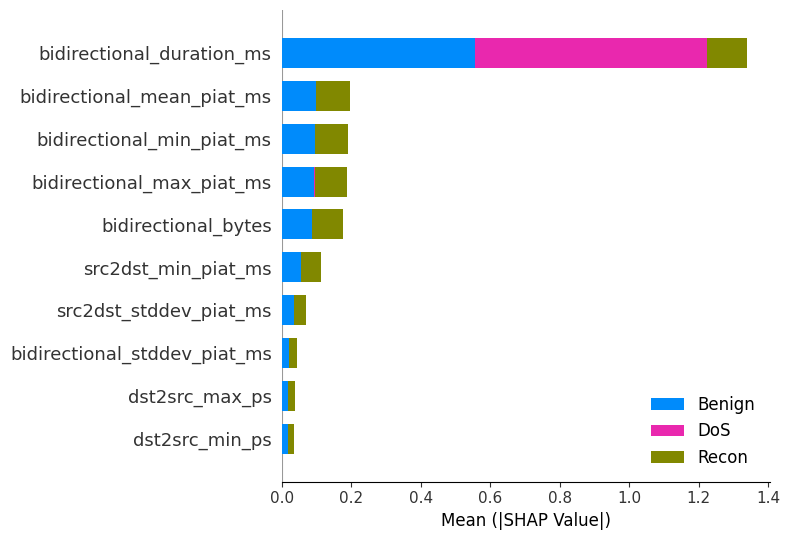

In [11]:
# Load the saved SHAP values
shap_values = joblib.load(f'mlp_model_shap_values.joblib')

# Define feature names and class names
feature_names = X_test.columns
class_names = ['Benign', 'DoS', 'Recon']

# Calculate mean absolute SHAP values across all classes and samples
mean_shap_values = np.mean(np.abs(shap_values).sum(axis=0), axis=0)

# Get indices of top 10 features
top_10_indices = np.argsort(mean_shap_values)[-10:][::-1]
top_features = feature_names[top_10_indices]

# Subset SHAP values and X_test for only the top 10 features
shap_values_top = [class_shap_values[:, top_10_indices] for class_shap_values in shap_values]
X_test_top = X_test[top_features]

# Plot SHAP summary plot for the top 10 features
shap.summary_plot(shap_values_top, X_test_top, feature_names=top_features, show=False)

# Modify legend to use real class names
legend = plt.gca().get_legend()
for i, text in enumerate(legend.get_texts()):
    text.set_text(class_names[i])

# Add a title and save the plot
# plt.gcf().text(0.5, 0.99, f'SHAP Summary Plot for {model_name}', ha='center', fontsize=15)
plt.xlabel("Mean (|SHAP Value|)", fontsize=12)
plt.savefig(f'mlp_model_shap_summary_plot_top10_features.pdf', bbox_inches='tight')
plt.show()


In [12]:
# Convert shap_values to a NumPy array
shap_values_array = np.array(shap_values)

# Check the number of dimensions and compute mean absolute SHAP values accordingly
if shap_values_array.ndim > 2:
    # For multi-class, average over both samples and classes
    mean_abs_shap_values = np.abs(shap_values_array).mean(axis=(0, 1))
else:
    # For binary or regression, average over samples only
    mean_abs_shap_values = np.abs(shap_values_array).mean(axis=0)

# Create the DataFrame with feature names and calculated mean absolute SHAP values
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'MeanAbsSHAP': mean_abs_shap_values
})

# Sort features by importance and calculate cumulative importance
feature_importance_df = feature_importance_df.sort_values(by='MeanAbsSHAP', ascending=False)
feature_importance_df['Cumulative Importance'] = feature_importance_df['MeanAbsSHAP'].cumsum()
total_importance = feature_importance_df['MeanAbsSHAP'].sum()
feature_importance_df['Cumulative Importance (%)'] = 100 * feature_importance_df['Cumulative Importance'] / total_importance

# Print the cumulative importance of the top 10 features
top_10_cumulative_importance = feature_importance_df.iloc[:10]['Cumulative Importance (%)'].iloc[-1]
print(f"The top 10 features contribute {top_10_cumulative_importance:.2f}% to the total feature importance.")


The top 10 features contribute 89.52% to the total feature importance.


In [ ]:
# For LSTM

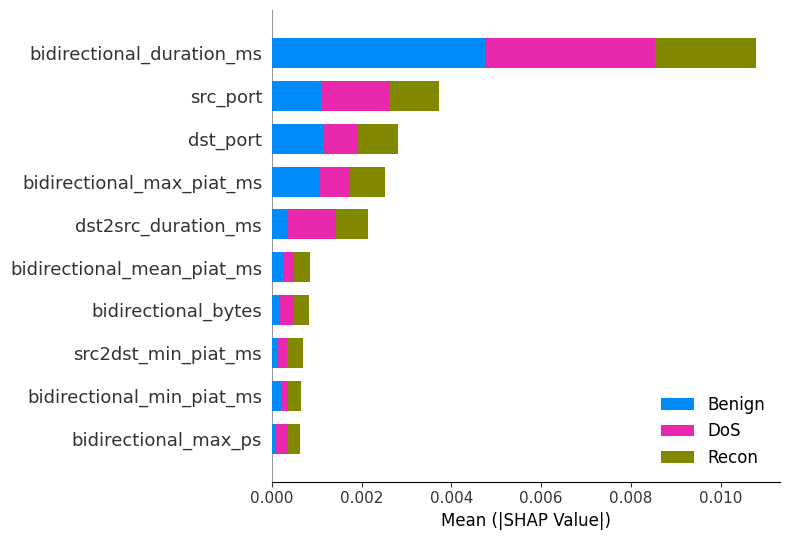

In [13]:
# Load the saved SHAP values
shap_values = joblib.load(f'lstm_model_shap_values.joblib')

# Define feature names and class names
feature_names = X_test.columns
class_names = ['Benign', 'DoS', 'Recon']

# Calculate mean absolute SHAP values across all classes and samples
mean_shap_values = np.mean(np.abs(shap_values).sum(axis=0), axis=0)

# Get indices of top 10 features
top_10_indices = np.argsort(mean_shap_values)[-10:][::-1]
top_features = feature_names[top_10_indices]

# Subset SHAP values and X_test for only the top 10 features
shap_values_top = [class_shap_values[:, top_10_indices] for class_shap_values in shap_values]
X_test_top = X_test[top_features]

# Plot SHAP summary plot for the top 10 features
shap.summary_plot(shap_values_top, X_test_top, feature_names=top_features, show=False)

# Modify legend to use real class names
legend = plt.gca().get_legend()
for i, text in enumerate(legend.get_texts()):
    text.set_text(class_names[i])

# Add a title and save the plot
# plt.gcf().text(0.5, 0.99, f'SHAP Summary Plot for {model_name}', ha='center', fontsize=15)
plt.xlabel("Mean (|SHAP Value|)", fontsize=12)
plt.savefig(f'lstm_model_shap_summary_plot_top10_features.pdf', bbox_inches='tight')
plt.show()


In [14]:
# Convert shap_values to a NumPy array
shap_values_array = np.array(shap_values)

# Check the number of dimensions and compute mean absolute SHAP values accordingly
if shap_values_array.ndim > 2:
    # For multi-class, average over both samples and classes
    mean_abs_shap_values = np.abs(shap_values_array).mean(axis=(0, 1))
else:
    # For binary or regression, average over samples only
    mean_abs_shap_values = np.abs(shap_values_array).mean(axis=0)

# Create the DataFrame with feature names and calculated mean absolute SHAP values
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'MeanAbsSHAP': mean_abs_shap_values
})

# Sort features by importance and calculate cumulative importance
feature_importance_df = feature_importance_df.sort_values(by='MeanAbsSHAP', ascending=False)
feature_importance_df['Cumulative Importance'] = feature_importance_df['MeanAbsSHAP'].cumsum()
total_importance = feature_importance_df['MeanAbsSHAP'].sum()
feature_importance_df['Cumulative Importance (%)'] = 100 * feature_importance_df['Cumulative Importance'] / total_importance

# Print the cumulative importance of the top 10 features
top_10_cumulative_importance = feature_importance_df.iloc[:10]['Cumulative Importance (%)'].iloc[-1]
print(f"The top 10 features contribute {top_10_cumulative_importance:.2f}% to the total feature importance.")


The top 10 features contribute 80.66% to the total feature importance.
